In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

SCRIPT_DIR = Path('/home/alina.smolina/DL-pipeline/src')
sys.path.append(str(SCRIPT_DIR))

In [3]:
import torch
import time
import glob

In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
import wandb

In [6]:
import pytorch_lightning as pl

🪄: shape of the resulting tensor is (10, 8000, 2379)


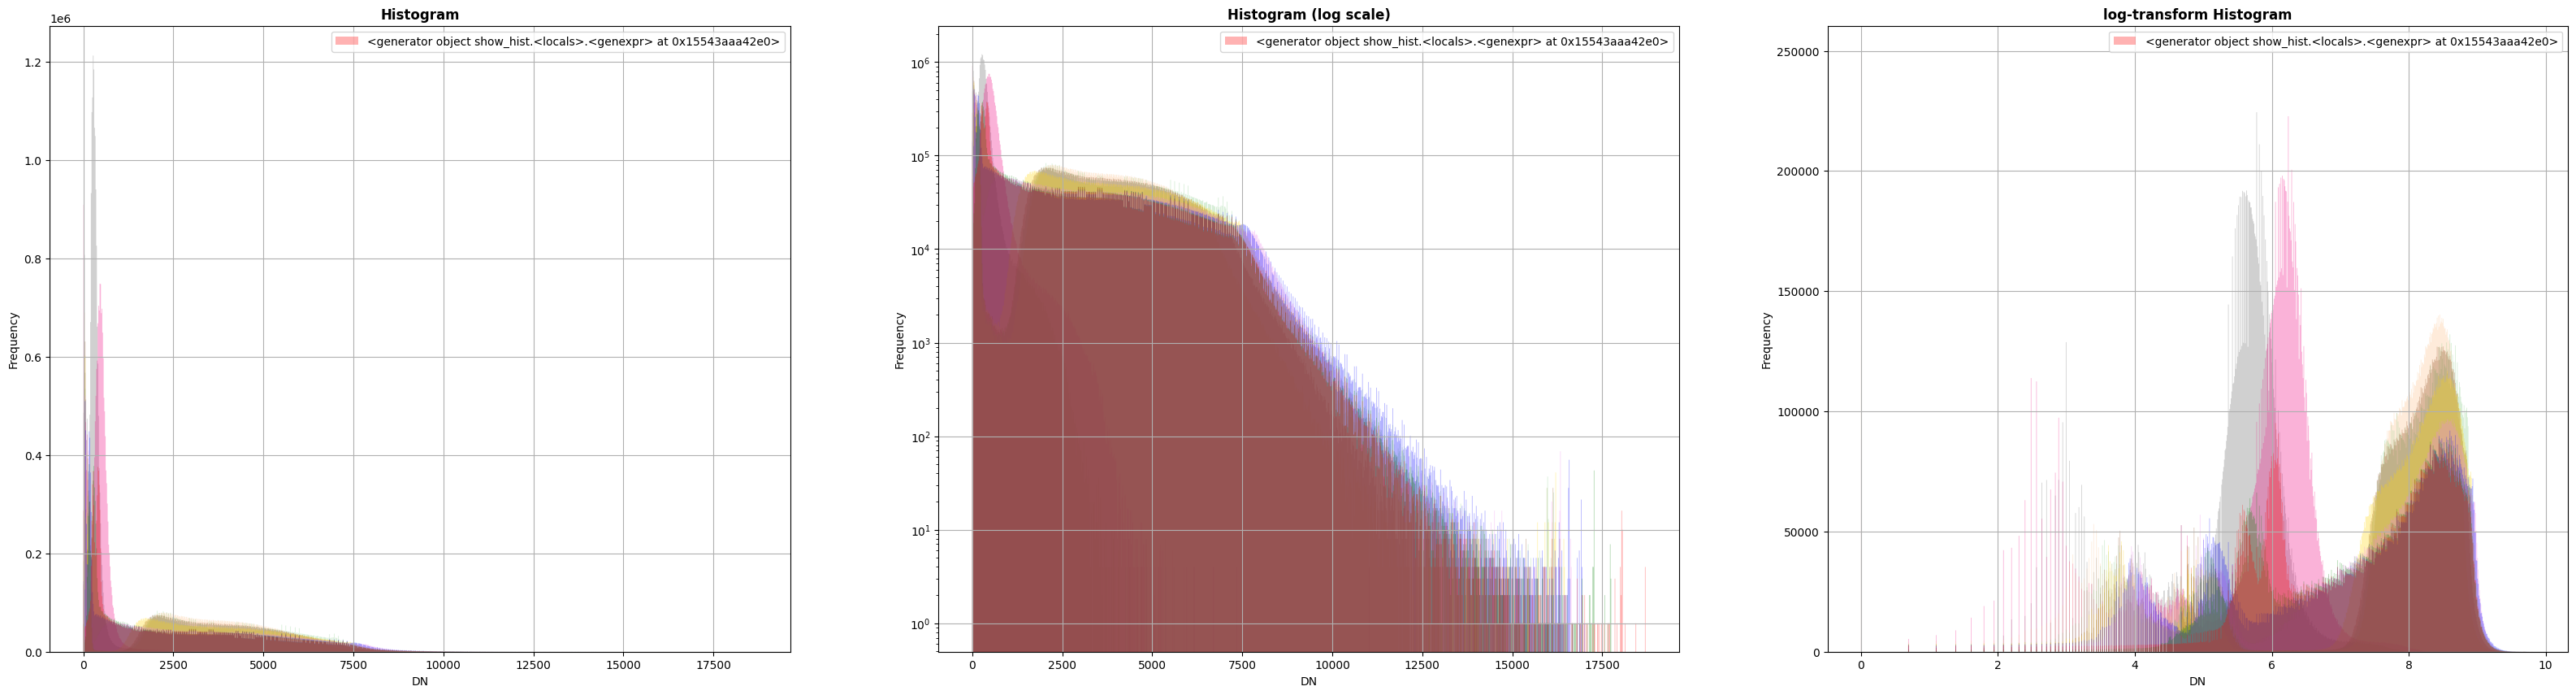

🪄: shape of the resulting tensor is (10, 2461, 2379)


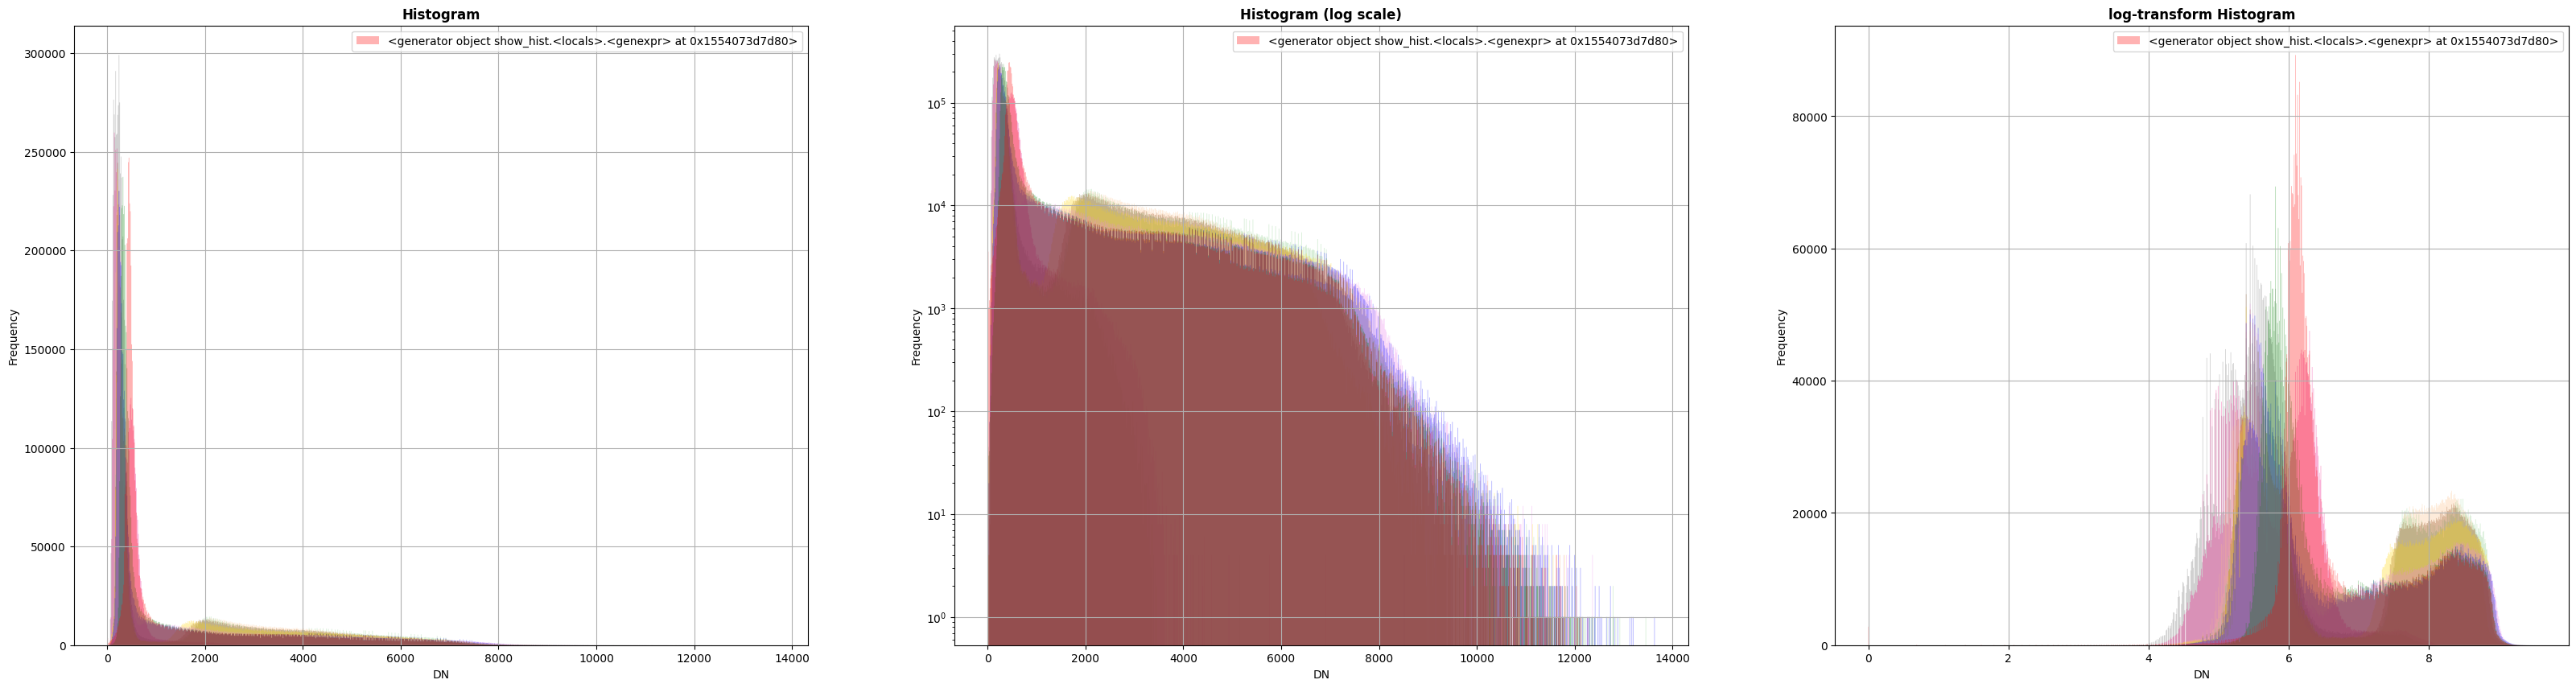

🪄: shape of the resulting tensor is (1, 8000, 2379)
🪄: shape of the resulting tensor is (1, 2461, 2379)
🪄: shape of the resulting tensor is (1, 8000, 2379)
🪄: shape of the resulting tensor is (1, 2461, 2379)


In [7]:
import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import show_hist
from pprint import pprint

### Korsak
# Get table with types and ages
# Target map shape is: (h, w) = (12775, 6965)

### Nevelsk
# Get table with types and ages
# Target map shape is: (h, w) = (10461, 2379)
#### -------------------------------> [x]
####|          ____________
####|         |            |
####|         |   TRAIN    |
####|         |            |
####|   (0, a).____________.(w, a)
####|         |            |
####|         |    TEST    |
####|         |            |
####|   (h, a).____________.(w, h)
####|
####|
####\/ [y]


h, w = 10461, 2379
a = 8000
y0, x0 = 0, 0
train_window = Window.from_slices((y0, y0 + a), (x0, x0 + w))
y0, x0 = a, 0
test_window = Window.from_slices((y0, h), (x0, x0 + w))

images_dir = './../data/images/nevelsk/20180401'
channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target_dir = './../data/images/nevelsk/rasterized'
target = '1layer_prevail_group_2groups'
# target = '1layer_prevail_group'


def get_data(channels_list, path, window=None, get_stat=False):
    channels = []
    for ch in channels_list:
        with rasterio.open(f'{path}/{ch}.tif') as src:
            if window is None:
                channels += [src.read(1)]
            else:
                channels += [src.read(1, window=window)]

    multispectral_img = np.stack(channels)
    print(f'🪄: shape of the resulting tensor is {multispectral_img.shape}')
    
    band_stats = {}
    
    if get_stat:
        
        flattened_multispectral_img = multispectral_img.reshape(multispectral_img.shape[0], -1)
        maximums = np.max(flattened_multispectral_img, axis=-1)
        minimums = np.min(flattened_multispectral_img, axis=-1)
        means = np.mean(flattened_multispectral_img, axis=-1)
        stds = np.std(flattened_multispectral_img, axis=-1)
        percentiles_99 = np.percentile(flattened_multispectral_img, q=99, axis=-1)
        percentiles_1 = np.percentile(flattened_multispectral_img, q=1, axis=-1)
        for i, ch in enumerate(channels_list):
            band_stats[ch] = {'min': minimums[i], 
                              'max': maximums[i], 
                              'mean': means[i], 
                              'std': stds[i],
                              'percentile_99': percentiles_99[i],
                              'percentile_1': percentiles_1[i],
                             }
        
        fig, axes = plt.subplots(1, 3, figsize=(40, 10))
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axes[0])
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram (log scale)", log=True, ax=axes[1])
        show_hist(np.log(multispectral_img), bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="log-transform Histogram", ax=axes[2])
        plt.show()

    return multispectral_img, band_stats


X_train, band_stats_train = get_data(channels_list, images_dir, window=train_window, get_stat=True)
X_test, _ = get_data(channels_list, images_dir, window=test_window, get_stat=True)

SCL_train, _ = get_data(['SCL'], images_dir, window=train_window)
SCL_test, _ = get_data(['SCL'], images_dir, window=test_window)

Y_train, _ = get_data([target], target_dir, window=train_window) 
Y_test, _ = get_data([target], target_dir, window=test_window)

# so that class indices are in the range [0,C) (for torch.nn.CrossEntropy)
Y_train = Y_train - 1
Y_test = Y_test - 1

In [9]:
# pprint(band_stats_train)

In [10]:
from datamodule import GeoModule 
import albumentations as A
import albumentations.pytorch as AP

transforms = A.Compose([
    # A.RandomCrop(256, 256),
    A.Flip(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625), 
        scale_limit=0, #no scale
        rotate_limit=(-90, 90), 
        p=0.5
    ),
    AP.ToTensorV2(transpose_mask=True),
    ],
    additional_targets={'mask0':'mask'}
)


one_date = GeoModule(
    X_train, 
    Y_train, 
    X_test, 
    Y_test,
    SCL_train,
    SCL_test,
    transform=None,#transforms,
    batch_size=64,
    patch_size=128, #512,
    stride = 64, # 512,
    norm_strategy='min_max',
)

In [11]:
import wandb
from module import SegModule
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

WANDB__SERVICE_WAIT=300
wandb_logger = WandbLogger(project='dl-pipeline', log_model=True)
print(f'🤖: Look at {wandb.run.url}')


lr_monitor_callback = LearningRateMonitor(logging_interval='step')


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'../weights/group-3classes/{wandb.run.name}/',
    filename='{epoch}-{val_loss:.2f}', 
    monitor='val/mean_acc',
    mode='max',
    save_top_k=1
)

                   
trainer = pl.Trainer(
    max_epochs=500, 
    benchmark=True, 
    check_val_every_n_epoch=10, 
    logger=wandb_logger, 
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
              ],
)

model = SegModule(
    optimizer='Adam', 
    scheduler='StepLR',
    step_size=200,
    gamma=0.3,
    lr=6e-3,
    in_channels=len(channels_list),
    num_classes=2, 
    ignore_index=255,
)

trainer.fit(model, one_date)

wandb: Currently logged in as: nali. Use `wandb login --relogin` to force relogin


🤖: Look at https://wandb.ai/nali/dl-pipeline/runs/gvi6ojvq


/trinity/home/alina.smolina/.conda/envs/torch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /trinity/home/alina.smolina/.conda/envs/torch/lib/py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


🤖: Setup data...
🤖: percentile_99 = [8100. 8096. 8480. 8439. 8167. 7700. 8200. 7239. 1801. 1326.]
🤖: percentile_1 = [ 1. 92. 30. 38. 20. 28. 20. 12. 10. 15.]
🤖: Dataset initialized:
🤖: ><><><><><><><><><> max_percentage_of_nodata_pixels = 0.6
🤖: ><><><><><><><><><> 0 patches were skipped
🤖: ><><><><><><><><><> 4464 are remaining


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                       | Params
-----------------------------------------------------------------
0  | net              | UNet                       | 16.5 M
1  | loss_fn          | CrossEntropyLoss_notmasked | 0     
2  | train_precision  | ClasswiseWrapper           | 0     
3  | train_recall     | ClasswiseWrapper           | 0     
4  | train_f1score    | ClasswiseWrapper           | 0     
5  | train_mean_acc   | MulticlassAccuracy         | 0     
6  | val_conf_matrix  | MulticlassConfusionMatrix  | 0     
7  | val_precision    | ClasswiseWrapper           | 0     
8  | val_recall       | ClasswiseWrapper           | 0     
9  | val_f1score      | ClasswiseWrapper           | 0     
10 | val_mean_acc     | MulticlassAccuracy         | 0     
11 | test_conf_matrix | MulticlassConfusionMatrix  | 0     
12 | test_precision   | ClasswiseWrapper           | 0     
13 | test_recall      | ClasswiseWrapper           

Sanity Checking: 0it [00:00, ?it/s]

🤖: #iterations in val dataloader: 14


/opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [13,0,0], thread: [928,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [13,0,0], thread: [929,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [13,0,0], thread: [930,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [13,0,0], thread: [617,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [13,0,0], thread: [618,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
trainer.test(datamodule=one_date)

# Etc.

In [8]:
# Y_train[Y_train == 0] = 255 # нет_данных № 255, 1, 2, 3
# Y_train[Y_train == 1] = 0 # лиственные № 255, 0, 2, 3
# Y_train[Y_train == 2] = 1 # хвойные № 255, 0, 1, 3
# Y_train[Y_train == 3] = 2 # смешанные № 255, 0, 1, 2
# Y_train[Y_train == 255] = 3 # нет_данных № 0, 1, 2, 3

# Y_test[Y_test == 0] = 255 # нет_данных № 255, 1, 2, 3
# Y_test[Y_test == 1] = 0 # лиственные № 255, 0, 2, 3
# Y_test[Y_test == 2] = 1 # хвойные № 255, 0, 1, 3
# Y_test[Y_test == 3] = 2 # смешанные № 255, 0, 1, 2
# Y_test[Y_test == 255] = 3 # нет_данных № 0, 1, 2, 3

# 1: 'лиственные',
# 2: 'хвойные',
# 3: 'смешанный',
# 0: 'нет_данных',

# стало

# 0: 'лиственные',
# 1: 'хвойные',
# 2: 'смешанный',
# 3: 'нет_данных',

In [ ]:
SPECIES_INFO = pd.read_csv(SCRIPT_DIR / 'species-v2.csv', sep=';', index_col=0)

def get_dict(key_column, values_column, SPECIES_INFO):
    keys_to_values_dict = SPECIES_INFO[[key_column, values_column]].set_index(key_column).T.to_dict('list')
    keys_to_values_dict = {k: v[0] for k, v in keys_to_values_dict.items()}
    return keys_to_values_dict

In [ ]:
code_group = get_dict('code_group', 'rus_group', SPECIES_INFO)

In [ ]:
def wb_mask(bg_img, pred_mask, true_mask):
    return 

In [ ]:
for val_iter in data_20180806.val_dataloader():
    data, label, scl = val_iter
    pred = trainer.predict(data)
    
    print(data.shape)
    print(label.shape)
    print(pred.shape)

In [ ]:
wandb.Image(bg_img, masks={
                           "prediction" : {"mask_data" : pred_mask, "class_labels" : [code_group[pix] for pix in pred_mask]},
                           "ground truth" : {"mask_data" : true_mask, "class_labels" : [code_group[pix] for pix in true_mask]}
                       }
                      )

In [ ]:
len(Y_test)

In [ ]:
# data_20180806.train_dataloader()

In [ ]:
trainer

In [ ]:
from datamodule import CustomDataset

ds_train = CustomDataset(X_train, Y_train, SCL_train, patch_size=512)
ds_test = CustomDataset(X_test, Y_test, SCL_test, patch_size=512)

In [ ]:
from rasterio.plot import show

In [ ]:
from torch.utils.data import random_split, DataLoader, Dataset
test_loader = DataLoader(
    ds_test, 
    shuffle=False, 
    batch_size=50,
    num_workers= 36,
    drop_last= False
)
train_loader = DataLoader(
    ds_train, 
    shuffle=False, 
    batch_size=50,
    num_workers= 36,
    drop_last= False
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize

group_to_color = get_dict('code_group', 'color_hex_group', SPECIES_INFO)

In [ ]:
get_dict('code_group', 'rus_group', SPECIES_INFO)

In [ ]:
get_dict('rus_group', 'color_hex_group', SPECIES_INFO)

In [ ]:
group_to_color

In [ ]:
wandb.l

def on_epoch_end(self, **kwargs):
    input_batch = self.learn.data.valid_ds[:self.num_to_log]
    mask_list = []
    for i, img_pair in enumerate(input_batch):
        original_image = img_pair[0]
        # the raw background image as a numpy array
        bg_image = image2np(original_image.data*255).astype(np.uint8)
        # run the model on that image
        prediction = learn.predict(original_image)[0]
        prediction_mask = image2np(prediction.data).astype(np.uint8)

        # ground truth mask
        ground_truth = img_pair[1]
        true_mask = image2np(ground_truth.data).astype(np.uint8)
        # keep a list of composite images
        mask_list.append(wb_mask(bg_image, prediction_mask, true_mask))

    # log all composite images to W&B
    wandb.log({"predictions" : mask_list})

In [ ]:
# Define the colormap and its bounds
mу_cmap = colors.ListedColormap([group_to_color[key] for key in group_to_color])
bounds = list(group_to_color.keys()) + [max(group_to_color) + 1]
norm = colors.BoundaryNorm(bounds, mу_cmap.N)

In [ ]:
from matplotlib.colors import ListedColormap
cmap1 = ListedColormap(colors, name='my-colors')

In [ ]:
import matplotlib.pyplot as plt

for i, items in enumerate(test_loader):
    data, label, scl  = items
    
    print(data.shape, label.shape, scl.shape)

fig, axes = plt.subplots(4, 4, figsize=(40,40))
for ax, label_crop in zip(axes.flatten(), label):
    show(label_crop.numpy(force=True), ax=ax, cmap=mу_cmap)
plt.tight_layout()
plt.show()

In [ ]:
for i, items in enumerate(train_loader):
    print(f'Batch: {i + 1}/{len(train_loader)}')
    data, label, scl  = items
    print(data.shape, label.shape, scl.shape)

    fig, axes = plt.subplots(12, 4, figsize=(40,120))
    for ax, label_crop in zip(axes.flatten(), label):
        show(label_crop.numpy(force=True), ax=ax, cmap='Reds')
    plt.tight_layout()
    plt.show()

# show((src, 1), ax=axr, cmap='Reds', title='red channel')

In [ ]:
A = CustomDataset(X_train, Y_train, SCL_train, size=450)

In [ ]:
len(A)

In [ ]:
for 

In [ ]:
from rasterio.plot import show

In [ ]:
A[9][0][1, :, :].shape

In [ ]:
show(A[15][1].numpy(force=True))

In [ ]:
A[15][1].numpy(force=True)

In [ ]:
show(A[15][0][[2, 1, 0], :, :].numpy(force=True).astype(int))

In [ ]:
show(A[59][2].numpy(force=True))

In [ ]:
A[9][0]